In [19]:
import nibabel as nib

import numpy as np
from PIL import Image

import os
from os.path import join
import glob

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [20]:
from nibabel import nicom

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  """Entry point for launching an IPython kernel.


In [35]:
UNCdir = '../../../sandbox/scansForSimulation/Siemens_UNC/series0017/'

In [36]:
siemensFiles = glob.glob(join(UNCdir, '*.IMA'))


In [37]:
import dicom

In [38]:
dcm = dicom.read_file(siemensFiles[0])

In [39]:
dcm.decode

<bound method Dataset.decode of (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008, 0012) Instance Creation Date              DA: '20171024'
(0008, 0013) Instance Creation Time              TM: '122736.733000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.2.43.67094.2017102412273592012006342
(0008, 0020) Study Date                          DA: '20171024'
(0008, 0021) Series Date                         DA: '20171024'
(0008, 0022) Acquisition Date                    DA: '20171024'
(0008, 0023) Content Date                        DA: '20171024'
(0008, 0030) Study Time                          TM: '113340.910000'
(0008, 0031) Series Time                         TM: '122736.730000'
(0008, 0032) Acquisition Time                    TM: '122522.750000'
(0008, 0033) Content Time                 

In [26]:
anat = nib.load('siemensOutput.nii.gz')
anat_data = anat.get_data()
anat_data.shape
hdr = anat.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 192 180  52   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          1.33333337  1.33333337  3.          1.          1.          1.
  1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : -0.5239736437797546
quatern_c       : -0.4954972565174103
quatern_d       : 0.4759955108165741
qoffset_x  

## Here's the affine from the WORKING saved nifti

In [47]:
cr_file = '20171024113341_T1w_MPR_17.nii.gz'
cr_anat = nib.load(join(UNCdir,cr_file))
cr_anat.shape

(52, 180, 192)

In [34]:
cr_affine = cr_anat.affine
np.set_printoptions(precision=3, suppress=True)
cr_affine

array([[   2.993,    0.074,    0.053,  -88.015],
       [  -0.167,    1.331,   -0.003,  -94.802],
       [  -0.12 ,   -0.   ,    1.332, -188.579],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

### Now, try to figure out how that was created

In [45]:
ImgOrientation = dcm.ImageOrientationPatient
voxSize = dcm.PixelSpacing
ImgOrientation = np.array(ImgOrientation)*voxSize[0]
ImgOrientation

array([ 0.074,  1.331,  0.   ,  0.053, -0.003, -1.332])

This shows that cr_affine[:3,1:2] are taken directly from the ImageOrientationPatient fields multiplied by the voxSize

In [100]:
myAnat = nib.load("siemensOutput.nii.gz")
myAnat_affine = myAnat.affine
myAnat_affine


array([[   0.074,    0.053,    2.993,  -88.151],
       [   1.331,   -0.003,   -0.167, -134.388],
       [   0.   ,   -1.332,    0.12 ,   59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

### Try to follow the dcm2nii code to recreate transform matrix

In [54]:
R = np.array(dcm.ImageOrientationPatient).reshape(3,2)
R

array([[ 0.056,  0.998],
       [ 0.   ,  0.04 ],
       [-0.002, -0.999]])

In [55]:
R = np.insert(R, 2, np.cross(R[:,0], R[:,1]), axis=1)
R

array([[ 0.056,  0.998,  0.   ],
       [ 0.   ,  0.04 ,  0.054],
       [-0.002, -0.999,  0.002]])

In [57]:
foo = abs(R)
foo

array([[ 0.056,  0.998,  0.   ],
       [ 0.   ,  0.04 ,  0.054],
       [ 0.002,  0.999,  0.002]])

In [61]:
ixyz = np.argmax(foo, axis=0)
ixyz

array([0, 2, 1])

In [62]:
ixyz[1] == ixyz[0]

False

In [64]:
np.any(ixyz[2] == ixyz[0:1])

False

In [65]:
iSL = ixyz[2]
iSL

1

In [66]:
cosSL = R[iSL, 2]
cosSL

0.053539833560661526

In [69]:
thk = dcm.SliceThickness
thk

'3'

In [80]:
pixDim = dcm.PixelSpacing
pixDim

['1.3333333730698', '1.3333333730698', '3', '3']

In [83]:
pixDim.append(thk)
pixDim

['1.3333333730698', '1.3333333730698', '3']

In [85]:
R = R * np.diag(pixDim)
R

array([[ 0.074,  0.   ,  0.   ],
       [ 0.   ,  0.053,  0.   ],
       [-0.   , -0.   ,  0.007]])

In [88]:
ipp = dcm.ImagePositionPatient
ipp

['-88.150703580322', '-134.38821883415', '59.742053192921']

In [89]:
R

array([[ 0.074,  0.   ,  0.   ],
       [ 0.   ,  0.053,  0.   ],
       [-0.   , -0.   ,  0.007]])

In [90]:
ixyz

array([0, 2, 1])

In [86]:
cr_affine

array([[   2.993,    0.074,    0.053,  -88.015],
       [  -0.167,    1.331,   -0.003,  -94.802],
       [  -0.12 ,   -0.   ,    1.332, -188.579],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [91]:
myAnat_affine

array([[   0.074,    0.053,    2.993,  -88.151],
       [   1.331,   -0.003,   -0.167, -134.388],
       [   0.   ,   -1.332,    0.12 ,   59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [92]:
test = myAnat_affine.copy()

In [102]:
cr_affine

array([[   2.993,    0.074,    0.053,  -88.015],
       [  -0.167,    1.331,   -0.003,  -94.802],
       [  -0.12 ,   -0.   ,    1.332, -188.579],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [103]:
myAnat2 = nib.load("siemensOutput2.nii.gz")
myAnat2_affine = myAnat2.affine
myAnat2_affine

array([[   2.993,    0.074,    0.053,  -88.151],
       [  -0.167,    1.331,   -0.003, -134.388],
       [  -0.12 ,    0.   ,    1.332,  -59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

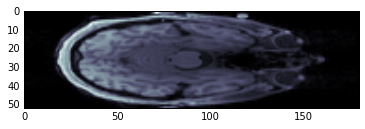

In [118]:
pylab.imshow(cr_anat.get_data()[:,:,100], cmap='bone')

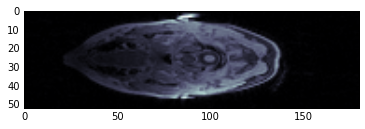

In [119]:
pylab.imshow(myAnat2.get_data()[:,:,130], cmap='bone')

### Notes:
In the CR data, the data is reoriented such that the voxel coords [0,0,0] correspond to RAS+ space. 
In my data, the image is oriented such that voxel coors [0,0,0] correspond to LPI. NEED TO FIX THIS.
ALSO, the affine transform is cloe

In [109]:
cr_anat.shape

(52, 180, 192)

In [34]:
from ipywidgets import interact

def display_sequence(images):
    def _show(frame=(0, len(images)-1)):
        return display_image(images[frame])
    return interact(_show)

def display_image(x):
    x_scaled = np.uint8(255 * (x / anat_data.max()))
    return Image.fromarray(x_scaled)

In [38]:
# image manipulation
anat_data = anat.get_data()
anat_data = np.rot90(anat_data, axes=(0,2))
#anat_data = np.rot90(anat_data, k=2, axes=(0,1))

slices = []
for i in range(anat_data.shape[2]):
    slices.append(anat_data[:,:,i])
display_sequence(slices)

interactive(children=(IntSlider(value=95, description='frame', max=191), Output()), _dom_classes=('widget-interact',))

<function __main__.display_sequence.<locals>._show>